# Insights from Failed Orders
---
## Background
Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Managemen (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

---

## Data Description

2 datasets: `data_orders` and `data_offers` being stored in CSV format are provided. 

The dataset `data_orders` contain:
- `order_datetime` - time of the order
- `origin_longtitude` - longtitude of the order
- `origin_latitude` - latitude of the order
- `m_order_eta` - time before order arrival
- `order_gk` - order number
- `order_status_key` - status of the order
    - `4` - cancelled by clinet, 
    - `9` - cancelled by system (a reject)
- `is_driver_assigned_key` - whether a driver has been assigned
- `cancellation_time_in_seconds` - how many seconds passed before cancellation

The dataset `data_offers` contain:
- `order_gk` - order number, associated with the same column from the `orders` dataset
- `origin_id` - ID of an offer

---

## Questions

1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?
2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?
3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?
4. Plot the distribution of average ETA by hours. How can this plot be explained?

---

## Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np

In [3]:
orders = pd.read_csv(filepath_or_buffer="datasets/data_orders.csv")

In [4]:
#rows, columns
orders.shape

(10716, 8)

In [5]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [6]:
offers = pd.read_csv(filepath_or_buffer="datasets/data_offers.csv")

In [7]:
offers.shape

(334363, 2)

In [8]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


As two datasets contain `orders` column in common, we may want to merge them into one for easier manipulation. 

In [9]:
df = orders.merge(right=offers, how='inner', on='order_gk')

In [10]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [11]:
df.rename(columns={'order_datetime': 'order_time'})

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275
...,...,...,...,...,...,...,...,...,...
31263,12:44:11,-0.975372,51.457846,NaN,3000597886155,4,0,43.0,300051590196
31264,12:42:52,-0.975372,51.457846,NaN,3000597886140,4,0,44.0,300051590176
31265,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.0,300051648809
31266,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.0,300051648910


The current values in two columns `order_status_key` and `is_driver_assigned_key` are not informative enough as they are in the forms of keys that relate to internal description. Therefore, the quality of the combined dataframe can be improved by mapping the current values with more meaningful ones such as `1` with `Yes` and `0` with `No`.

In [12]:
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

In [13]:
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [14]:
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,198.0,300050983403,Yes,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986180,No,Client Cancelled
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled


At this point, the combined dataframe is ready for analysing.

## Question 1

**Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?**

To build a distribution based on two types of reasons for failure, a pivot table is recommended as each column has only 2 possible values. Therefore, 4 possible combinations of values can be generated. 

In [27]:
fail_dist = df.pivot_table(columns=['is_driver_assigned', 'order_status'], values=['order_gk'] , aggfunc='count')
fail_dist

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

It is clear that a higher number of cancelled orders happen before a driver is successfully assigned, indicating that highly due to long waiting time, customers decided on transportation alterantives. Specifically, `13435` orders were cancelled by client and `9469` by the system. There are `8360` orders cancelled by client and only `4` by the system after a driver was assigned. 

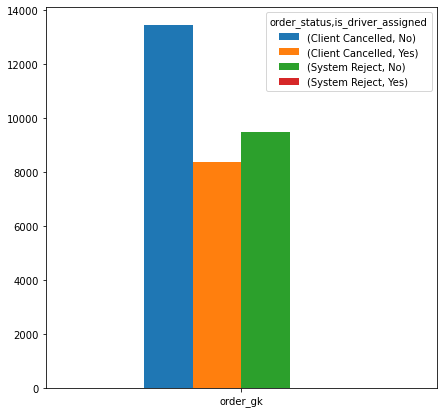

In [23]:
pl1 = fail_dist.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)

## Question 2

## Question 3

## Question 4